In [1926]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join('/Users/cd8607/Documents/Lammps_MD/', 'git_folder', 'Classes'))
import EAM_Fitting_Serial
import Handle_PotFiles
import time
import glob
from scipy.optimize import minimize
os.chdir('/Users/cd8607/Documents/Lammps_MD')
from scipy.integrate import simpson

In [1927]:
def he_h_potential(r, zbl):
    D0 = -0.318151 
    D1 = 1.142826 
    D2 = -0.530526 
    D3 = 0.116766 
    sigma = 3.0862 
    e = 0.0006 
    r1 = 0.5 
    r2 = 2.5

    if r < r1:
        return zbl.eval_zbl(r)
    
    elif r1 < r <= r2:
        return D0 + D1/r + D2/r**2 + D3/r**3
    
    else:
        return 4*e*( (sigma/r) **12 - (sigma/r) ** 6)

def Beck1968(r):

    A = 398.7
    a = 0.675
    alpha = 4.390
    beta = 3.746e-4

    return  A*np.exp(-alpha*r - beta*r**6) - (0.869/((r**2 + a**2)**3)) * (1 + ((2.709 + 3*a**2)/(r**2 + a**2)))

zbl_hhe = EAM_Fitting_Serial.ZBL(2, 1)

zbl_whe = EAM_Fitting_Serial.ZBL(74, 2)

zbl_hehe = EAM_Fitting_Serial.ZBL(2, 2)

alat = 3.14221
r = alat * np.array([np.sqrt(5)/4, np.sqrt(3)/2])

print(zbl_whe.eval_zbl(r))
print(zbl_whe.eval_grad(r))
print(zbl_whe.eval_hess(r))


mean = np.array([0.37, 1, -2, 1, -1, 0.5, 0.5, -0.5, 0.5, -0.8, 0, 0, 0.5, 0, 0])

cov = 0.01*np.diag([0.2, 1, 1, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 1, 1, 0.25, 0.5, 0.5])

print(np.random.multivariate_normal(mean=mean, cov=cov))


[2.83461642 0.26500004]
[-7.97867786 -0.581132  ]
[25.17565205  1.37472214]
[ 0.35438912  0.99335865 -1.79476475  1.1513092  -0.97118799  0.43815427
  0.52367356 -0.59085645  0.51170889 -0.74892269  0.04434994  0.12930104
  0.4397829  -0.0676242   0.02200863]


In [1928]:
he_p = np.sin(np.arange(0, 5))

sort_idx = np.argsort(he_p)

loss = 0

if not (sort_idx == np.arange(len(he_p))).all():
    
    loss = 1000

print( (sort_idx == np.arange(len(he_p))).all() )

False


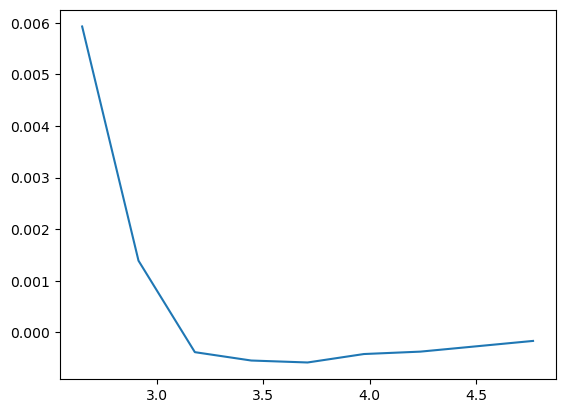

In [1929]:
r = 0.52977 * np.array([5, 5.5, 6, 6.5, 7, 7.5, 8, 9])

kb = 8.6173303e-5	

e_K = np.array([68.8, 16.10, -4.48, -6.36, -6.8, -4.9, -4.36, -1.95])

plt.plot(r, kb * e_K)

pairwise_he_he = np.array([ [3.0 , 3812.0],
                            [4.5, 60.0],
                            [5.0, -0.41],
                            [5.6, -11.01],
                            [6.6, -6.25],
                            [7.5, -3.05],
                            [9.0, -0.96], ])
pairwise_he_he[:,0] *= 0.52977
pairwise_he_he[:,1] *= kb


In [1930]:
virial_coef_he_he = np.array([
        [2.47734287e+01, 5.94121916e-01],
        [2.92941502e+01, 2.40776488e+00],
        [3.07958539e+01, 3.83040639e+00],
        [3.68588657e+01, 5.40986938e+00],
        [4.17479885e+01, 6.53497823e+00],
        [4.46858331e+01, 7.17968070e+00],
        [4.75019178e+01, 8.38570392e+00],
        [5.37647405e+01, 9.02532656e+00],
        [6.15199008e+01, 9.93664731e+00],
        [6.60125239e+01, 1.03170537e+01],
        [7.25313543e+01, 1.06944122e+01],
        [8.24001392e+01, 1.14797533e+01],
        [9.07328778e+01, 1.17820755e+01],
        [1.17039231e+02, 1.21403483e+01],
        [1.41069613e+02, 1.20965893e+01],
        [1.67450895e+02, 1.21365022e+01],
        [1.93516850e+02, 1.21478229e+01],
        [2.41917917e+02, 1.21190856e+01],
        [2.67315755e+02, 1.20323657e+01],
        [2.91396089e+02, 1.19211176e+01],
        [2.68130785e+02, 1.18153354e+01],
        [3.17493260e+02, 1.16470198e+01],
        [3.69327808e+02, 1.14298383e+01],
        [4.19601366e+02, 1.11111245e+01],
        [4.67439296e+02, 1.10837355e+01],
        [5.70002943e+02, 1.08218509e+01],
        [6.68648934e+02, 1.04696549e+01],
        [7.63553410e+02, 1.01675917e+01],
        [8.72549304e+02, 9.91475627e+00],
        [1.07102569e+03, 9.29054054e+00],
        [1.26456401e+03, 8.73262548e+00],
        [1.47116726e+03, 8.23063465e+00]
        ])

pairwise_h_he = np.column_stack([r, kb * e_K])

In [1931]:
def loss_he_he(x, eam_fit, virial_ref, pairwise_ref):

    loss = 0

    eam_fit.sample_to_file(x)

    r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

    phi = eam_fit.pot_lammps['He-He'][1:] / r
    
    coef_dict = eam_fit.fit_sample(x)
    
    virial_pot = np.zeros((len(virial_ref), ))
    
    conv = 6.02214e-1

    for i, T in enumerate(virial_ref[:,0]):

        kb = 8.6173303e-5

        beta = 1 / (kb * T)

        phi = np.clip(phi, a_max=10, a_min=-10)
        
        y = ( 1 - np.exp(-beta * phi) ) * r**2

        virial_pot[i] = 2* np.pi * conv * simpson(y, x=r)
        
    loss = np.sum((virial_pot - virial_ref[:,1])**2, axis = 0)

    coef_dict = eam_fit.fit_sample(x)

    ZBL = EAM_Fitting_Serial.ZBL(2, 2)

    poly = EAM_Fitting_Serial.splineval(pairwise_ref[:, 0], coef_dict['He-He'], eam_fit.knot_pts['He-He'])

    zbl = ZBL.eval_zbl(pairwise_ref[:, 0])

    phi_pot = poly + zbl
    
    loss += np.sum((phi_pot - pairwise_ref[:, 1])**2, axis=0)

    return loss

In [1974]:
pot, potlines, pot_params = Handle_PotFiles.read_pot('Fitting_Runtime/Potentials/optim.0.eam.alloy')

n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 4
n_knots['H-He'] = 0

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['He-He'][1:-1]

zbl = zbl_hehe.eval_zbl(knot_pts)
zbl_grad = zbl_hehe.eval_grad(knot_pts)
zbl_hess = zbl_hehe.eval_hess(knot_pts)


h = 1e-4

beck = Beck1968(knot_pts)
beck_grad = (Beck1968(knot_pts + h) - Beck1968(knot_pts))/ h
beck_hess = (Beck1968(knot_pts + h) - 2*Beck1968(knot_pts) + Beck1968(knot_pts - h))/ h**2

zbl_arr = []
beck_arr = []

for i in range(len(knot_pts)):
    zbl_arr.append([zbl[i], zbl_grad[i], zbl_hess[i]])
    beck_arr.append([beck[i], beck_grad[i], beck_hess[i]])

zbl_arr = np.array(zbl_arr).flatten()
beck_arr = np.array(beck_arr).flatten()

sample = beck_arr - zbl_arr

print(beck_arr)

print(sample)

sample = np.array([-0.34777945,  0.45992866, -0.52837101, -0.0268438,   0.04093725, -0.06855827])

# sample = np.array([-2.46786904e-02, -2.93069418e+00,  1.66242914e+01, -1.06257599e-01,
#   1.76171523e-01, -1.97547330e-01, -1.44369448e-02,  2.20691089e-02,
#  -5.44973771e-02])
loss = loss_he_he(sample, eam_fit, virial_coef_he_he, pairwise_he_he)

print(loss)

[ 2.57187026e-01 -1.18089096e+00  5.22815753e+00 -7.40444400e-04
  8.60722892e-04  5.26667533e-04]
[-0.3300847   0.19312916  1.57674155 -0.02723076  0.04318023 -0.07501947]
2.0034940761531606


In [1975]:
sample += 1e-2*np.random.random(sample.shape)
res = minimize(loss_he_he, sample, args=(eam_fit, virial_coef_he_he, pairwise_he_he), method='Nelder-Mead', options={'maxiter':1e5})

print(res)
eam_fit.sample_to_file(res.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.133606727915736
             x: [-3.416e-01  4.388e-01 -4.957e-01 -2.708e-02  3.996e-02
                 -5.654e-02]
           nit: 469
          nfev: 749
 final_simplex: (array([[-3.416e-01,  4.388e-01, ...,  3.996e-02,
                        -5.654e-02],
                       [-3.416e-01,  4.389e-01, ...,  3.996e-02,
                        -5.654e-02],
                       ...,
                       [-3.416e-01,  4.388e-01, ...,  3.996e-02,
                        -5.654e-02],
                       [-3.416e-01,  4.388e-01, ...,  3.996e-02,
                        -5.653e-02]]), array([ 2.134e+00,  2.134e+00,  2.134e+00,  2.134e+00,
                        2.134e+00,  2.134e+00,  2.134e+00]))


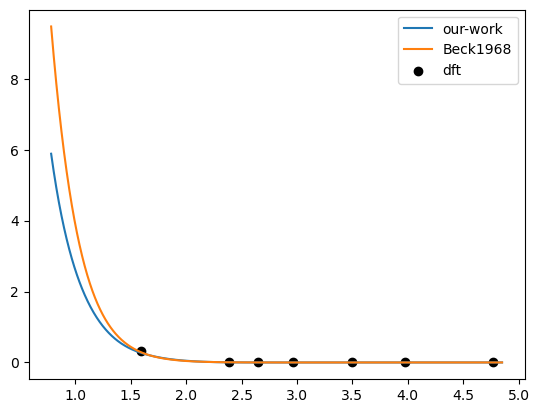

In [1978]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['He-He'][1:] / r

plt.plot(r[200:], phi[200:], label='our-work')

plt.plot(r[200:], Beck1968(r[200:]), label = 'Beck1968')

plt.scatter(pairwise_he_he[:,0], pairwise_he_he[:,1], label='dft', color='black')
plt.legend()

In [1973]:
print(res.fun, res.x)

2.003493995371375 [-0.34777945  0.45992866 -0.52837101 -0.0268438   0.04093725 -0.06855827]


In [1970]:
def eval_virial(phi, T_arr, r, dr):

    virial_coef = np.zeros(T_arr.shape)
    
    kb = 8.6173303e-5
    
    conv = 6.02214e-1

    for i, T in enumerate(T_arr):

        beta = 1 / (kb * T)

        y = ( 1 - np.exp(-beta * phi) ) * r**2

        virial_coef[i] = 2* np.pi * conv * simpson(y,x=r)

    return virial_coef

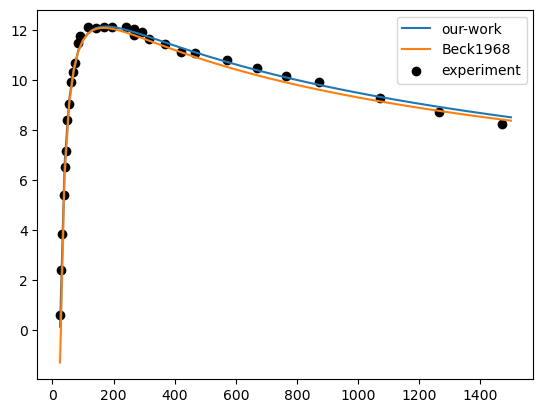

In [1979]:
T_arr = np.linspace(25, 1500, 100)

virial_beck = eval_virial(Beck1968(r), T_arr, r, dr)

virial_pot = eval_virial(phi, T_arr,r, dr)

plt.plot(T_arr, virial_pot, label='our-work')

plt.plot(T_arr, virial_beck, label='Beck1968')

plt.scatter(virial_coef_he_he[:,0], virial_coef_he_he[:,1], color='black',label='experiment')

plt.legend()

In [1982]:
def loss_h_he(x, eam_fit, ref):

    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    ZBL = EAM_Fitting_Serial.ZBL(2, 1)

    poly = EAM_Fitting_Serial.splineval(ref[:, 0], coef_dict['H-He'], eam_fit.knot_pts['H-He'])

    zbl = ZBL.eval_zbl(ref[:, 0])

    phi_pot = poly + zbl
    
    loss = np.sum((phi_pot - ref[:, 1])**2, axis=0)
    return loss

def LJ(x, r):
    e = x[0]

    sigma = x[1]
    
    y = 4 * e * ((sigma/r)**12 - (sigma/r)**6)

    return y

def LJ_hhe(x, ref):

    y = LJ(x, ref[:, 0])
    
    loss = np.sum((1 - y/ref[:, 1])**2, axis=0)

    return loss

[5.8597846e-04 3.0000000e+00]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.22922565140055376
             x: [ 6.026e-04  3.059e+00]
           nit: 22
          nfev: 44
 final_simplex: (array([[ 6.026e-04,  3.059e+00],
                       [ 6.025e-04,  3.059e+00],
                       [ 6.024e-04,  3.059e+00]]), array([ 2.292e-01,  2.292e-01,  2.292e-01]))


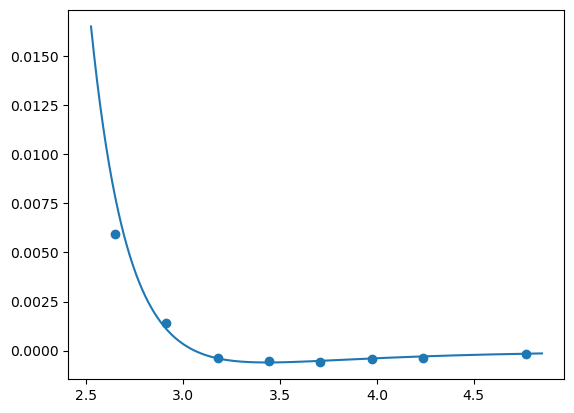

In [2024]:
x0 = np.array([ abs(pairwise_h_he[:,1].min()), 3])
print(x0)

lj_res = minimize(LJ_hhe, x0, args=(pairwise_h_he), method='Nelder-Mead')

r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[650:]

print(lj_res)

plt.plot(r, LJ(lj_res.x, r))

plt.scatter(pairwise_h_he[:,0], pairwise_h_he[:,1])

In [2020]:
n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 4

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['H-He'][1:-1]

zbl = zbl_hehe.eval_zbl(knot_pts)
zbl_grad = zbl_hehe.eval_grad(knot_pts)
zbl_hess = zbl_hehe.eval_hess(knot_pts)


h = 1e-4

lj = LJ(lj_res.x, knot_pts)
lj_grad = (LJ(lj_res.x, knot_pts + h) -   LJ(lj_res.x, knot_pts))/ h
lj_hess = (LJ(lj_res.x, knot_pts + h) - 2*LJ(lj_res.x, knot_pts) + LJ(lj_res.x ,knot_pts - h))/ h**2


zbl_arr = []
lj_arr = []

for i in range(len(knot_pts)):
    zbl_arr.append([zbl[i], zbl_grad[i], zbl_hess[i]])
    lj_arr.append([lj[i], lj_grad[i], lj_hess[i]])

zbl_arr = np.array(zbl_arr).flatten()
lj_arr = np.array(lj_arr).flatten()

sample = lj_arr - zbl_arr

print(sample)

sample[:3] = 0

# sample = np.array([-1.766e-01,  1.778e-01,  8.775e-02, -1.851e-02,  2.658e-02, -4.260e-02])

loss_h_he(sample, eam_fit, pairwise_h_he)

[ 4.36380236e+00 -3.57605083e+01  2.96511797e+02 -2.69804274e-02
  4.09368661e-02 -6.40468042e-02]


0.00024825830210676095

In [2021]:
res = minimize(loss_h_he, sample, args=(eam_fit, pairwise_h_he), method='Nelder-Mead')

print(res)

eam_fit.sample_to_file(res.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.159267985759638e-08
             x: [-1.766e-01  1.778e-01  8.775e-02 -1.851e-02  2.658e-02
                 -4.260e-02]
           nit: 249
          nfev: 393
 final_simplex: (array([[-1.766e-01,  1.778e-01, ...,  2.658e-02,
                        -4.260e-02],
                       [-1.767e-01,  1.779e-01, ...,  2.657e-02,
                        -4.253e-02],
                       ...,
                       [-1.766e-01,  1.778e-01, ...,  2.659e-02,
                        -4.262e-02],
                       [-1.766e-01,  1.778e-01, ...,  2.659e-02,
                        -4.256e-02]]), array([ 6.159e-08,  6.159e-08,  6.159e-08,  6.160e-08,
                        6.161e-08,  6.163e-08,  6.164e-08]))


-0.0006306538406157421 3.585133685476381 -0.0005859784603999999


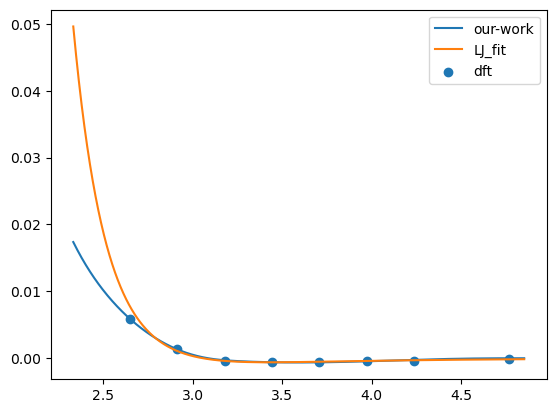

In [2026]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['H-He'][1:] / r

plt.plot(r[600:], phi[600:], label='our-work')

plt.plot(r[600:], LJ(lj_res.x, r[600:]), label='LJ_fit')

plt.scatter(pairwise_h_he[:,0], pairwise_h_he[:,1], label='dft')

plt.legend()

print(phi.min(), r[phi.argmin()], pairwise_h_he[:,1].min())

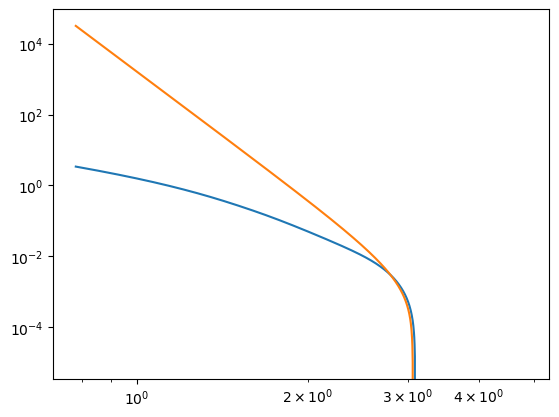

In [2035]:
plt.loglog(r[200:], phi[200:])
plt.loglog(r[200:], LJ(lj_res.x, r[200:]))

In [2044]:
n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 4
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 0

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


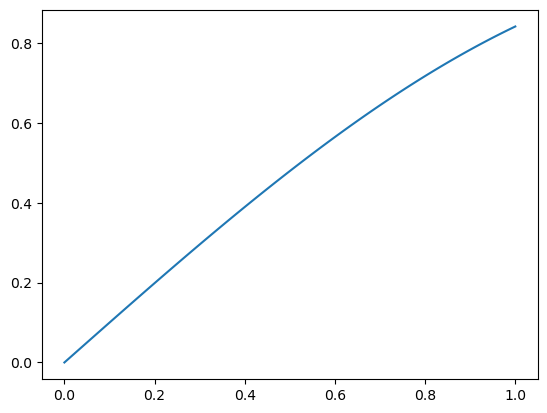

In [2047]:

x = np.linspace(0, 1, 100)

y = np.sin(x)

sort_idx = np.argsort(y)
plt.plot(x, y)

print(sort_idx)
if not (sort_idx == np.arange(len(y))).all():
    print('not monotonously decreasing')